In [1]:
import os
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import rich
import gseapy as gp

from IPython.display import display
from rich.panel import Panel
from gseapy import gseaplot
from statannotations.Annotator import Annotator
from pathlib import Path
from scBTF import SingleCellTensor, SingleCellBTF, FactorizationSet, Factorization

sc.logging.print_header()
sc.settings.njobs = 32

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


## 1. Load Config and Data

In [2]:
CONFIG_FILE = '.config_ipynb'

if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as f:
        sys.argv = f.read().split()
else:
    sys.argv = ['stub.py']
parser = argparse.ArgumentParser()
parser.add_argument("--adata_path",help="path to adata object, expects log normalized X")
parser.add_argument("--factorization_path",help="path to scBTF factorization result, .pkl format")
parser.add_argument("--rank", type=int, help="rank")
parser.add_argument("--factor", type=int, help="factor")

args = parser.parse_args()

rich.print(args)
globals().update(vars(args))

Namespace(adata_path='/home/dchafamo/final/data/combined_dataset_final_v2.h5ad', 
factorization_path='/home/dchafamo/scBTF/results/hgnc_hals_consensus_factorization.pkl', rank=24, factor=23)

In [3]:
adata = sc.read(adata_path)
print(adata.shape)

(308403, 29786)


In [4]:
reconstructed_all = FactorizationSet.load(factorization_path)
reconstructed_all

Single cell factorization object with the following params:
        Tensor size 15 x 15 x 17147
        Ranks: [16, 24, 20]

## 2. Summary plot of factor

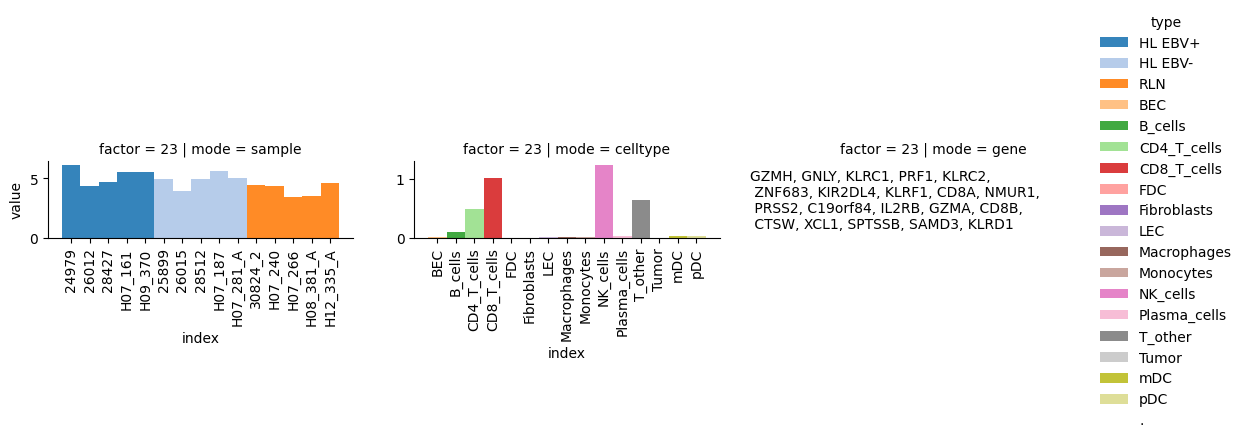

In [28]:
"""
    
    Factor loadings for samples in the first panel and celltypes in the second panel. 
    Third panel gives the gene program extracted from the gene loadings of the factor
    
"""

fig = reconstructed_all.plot_components(
    rank=rank, 
    restart_index=0, 
    threshold = 0.7,
    entropy = 1, 
    eps = 0, 
    sort_by = 'other',
    plot_erichment_terms=False, 
    factors = [str(factor)],
    normalize_gene_factors=True, 
    title=False
)

## 3. Celltypes in which this Factor is Active

In [30]:
""" 

    We identify the celltypes that have loadings above the (adjustable) threshold after normalization.
    These are the celltypes in which the GEPs in this factor are active.

"""

threshold = 0.3

factorization = reconstructed_all.get_factorization(rank=rank, restart_index=0)
ct_factor = factorization.celltype_factor['mean'].numpy()[:,factor]
ctypes = pd.DataFrame([
    reconstructed_all.sc_tensor.celltype_list[ct_factor/ct_factor.max() > threshold], 
    ct_factor[ct_factor/ct_factor.max() > threshold]
]).T
rich.print(f'Celltypes loading on this factor are:\n{ctypes.to_markdown(index=False)}')

Celltypes loading on this factor are:
| 0           |        1 |
|:------------|---------:|
| CD4_T_cells | 0.480245 |
| CD8_T_cells | 1.00234  |
| NK_cells    | 1.23582  |
| T_other     | 0.640386 |

## 4. Factor GEP on UMAP 

... storing 'orig.ident' as categorical
... storing 'gem_lane' as categorical
... storing 'donor' as categorical
... storing 'institution' as categorical
... storing 'condition' as categorical
... storing 'tissue_site' as categorical
... storing 'histo_subtype' as categorical
... storing 'sex' as categorical
... storing 'seq_tech' as categorical
... storing 'SingleR.labels.hpca' as categorical
... storing 'SingleR.labels.encode' as categorical
... storing 'SingleR.labels.dice.main' as categorical
... storing 'SingleR.labels.dice.fine' as categorical
... storing 'SingleR.labels.monaco.main' as categorical
... storing 'SingleR.labels.monaco.fine' as categorical
... storing 'SingleR.labels.steidl.basic' as categorical
... storing 'SingleR.labels.steidl.int' as categorical
... storing 'SingleR.labels.steidl.fine' as categorical
... storing 'cell_types_level_3' as categorical
... storing 'Immune_All_Low.predicted_labels' as categorical
... storing 'Immune_All_Low.majority_voting' as categor

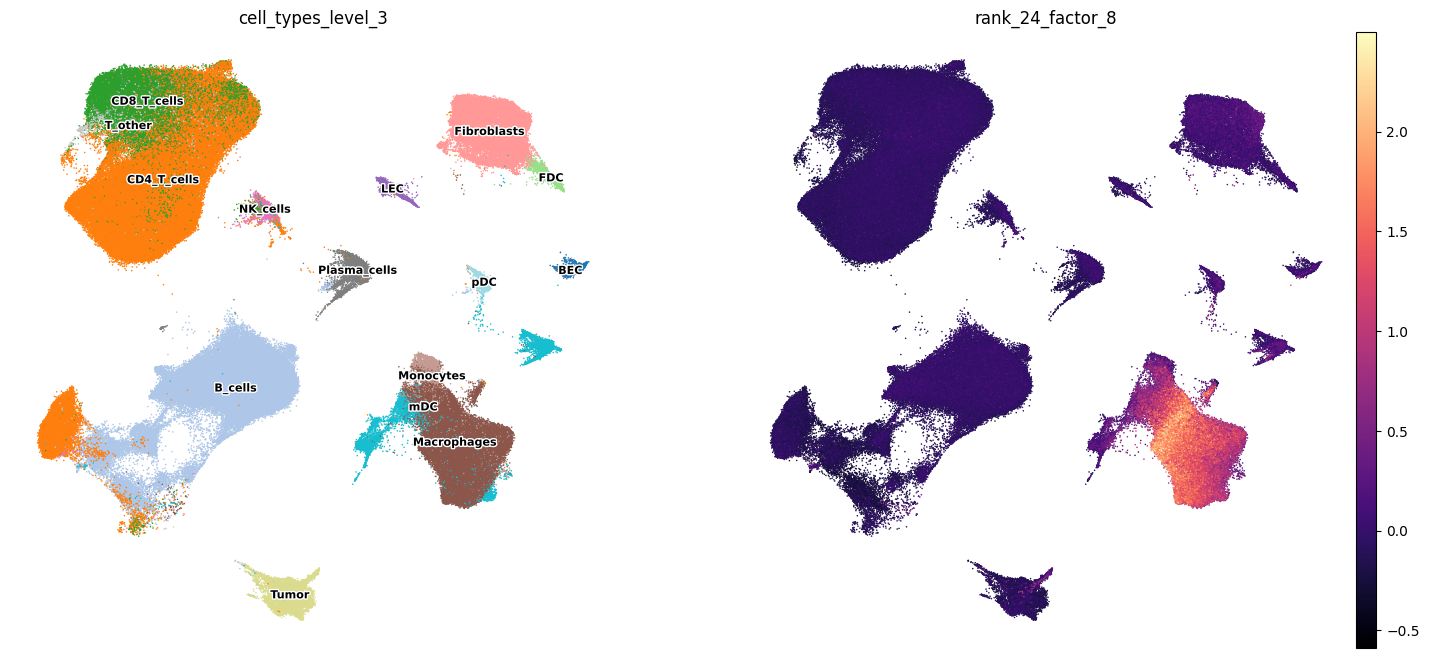

In [138]:
"""

    We define the gene program using a conjunction of specificity filters and absolute loading magnitude filters. 
    Other approaches like using top n genes can also be used.
    
"""

gene_programs = reconstructed_all.get_gene_programs(
    rank, 0, normalize_gene_factors=True, threshold=0.6, sort_by='other', entropy=1, eps=0
)
sc.pp.scale(adata, zero_center=False)
sc.tl.score_genes(adata, gene_programs[factor], score_name = f'rank_{rank}_factor_{factor}', use_raw=False)
with plt.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color=['cell_types_level_3', f'rank_{rank}_factor_{factor}'], wspace=0.1, add_outline=False, cmap='magma',
               legend_loc='on data', size=5, palette='tab20',legend_fontsize=8, legend_fontoutline=2,frameon=False)

## 5. Statistical test for sample loadings

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HL EBV+ vs. HL EBV-: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
HL EBV- vs. RLN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=2.500e+01
HL EBV+ vs. RLN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=2.500e+01


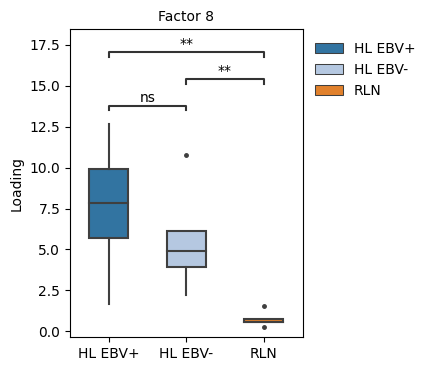

In [139]:
"""

    We run a Mann-Whitney-Wilcoxon test two-sided test on the sample loadings across different sample groups.
    
"""

fig = reconstructed_all.sample_factor_correlation(
    rank = rank, restart_index = 0, 
    x = "sample_type", y = factor, 
    order = ["HL EBV+", "HL EBV-", "RLN"], 
    pairs = [("HL EBV+", "HL EBV-"), ("HL EBV+", "RLN"), ("HL EBV-", "RLN")]
)
plt.show()

## 6. Gene Expression Program

╭───────────────────────────── Filtered genes based on entropy and absolute loading ──────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ FBP1    CCL18   MMP12   ALOX15B DCSTAMP ORM1    CDCP1   FPR3    CD163   SULT1C2 NT5DC4  ALOX15  MT1H    NDP     │
│ MEP1A   SLC7A11 F13A1   NR1H3   LILRB4  PLAU    HTRA4   HK3     ASGR1   CLEC5A  OLR1    VENTX   FMN1    SLC1A3  │
│ MITF    MMP2    ST18    NOS1AP  NPFFR1  SLC16A10        CAPG    KCNE1   OLFML2B IL22RA2 CLEC6A  CYP27B1 VSIG4   │
│ TMEM150B        GPR84   CES1    CCL8    SULT1C3 KYNU    SLC39A8 RASAL2  RASSF4  SH3PXD2B        KMO     FLVCR2  │
│ TRPM2   GGT5    FHAD1   TMEM144 MMP14   OSCAR   FCGR2B  ACP5    VNN1    SLC6A7  LRRC74A ZNF697  TMPRSS13        │
│ PLXDC2  FAM20A  ARHGEF10L       TMEM51  ITGAM   TGFBI   VASH1   ARRDC4  VAMP8   DPYS    CARD9   HBEGF   MT1X    │
│ MYEOV   CDX1    PRSS36  GAL3ST4 NPL     TFEC    STEAP3  SLC6A12 SLC7A7  CSF2RA  SPRED1  PFKFB4  CISH    PLTP    │
│ CKAP2L  ACE     ADAMDEC1        CTSB    CYP27A1 SLC47A1 MYOF    ZMYND15 PLA2G7  FCRLB   ZNF385A MT1G    IGFBP2  │
│ TFCP2L1 ASGR2   SLC30A4 KCNN4   MRC1    SIGLEC15        SLC37A2 DMXL2   CACNA1G ATP6V0D2        SEMA3C  CYP2S1  │
│ ITGAX   EPOP    OSM     SLC22A15        CTTNBP2 HS3ST2  P2RY1   KIFC3   UPP1    TSKU    SIGLEC7 SLC4A1  HNMT    │
│ PTGER2  EIF3G   GADD45G CMKLR1  LRP1    CASQ1   HRH1    ICAM5                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

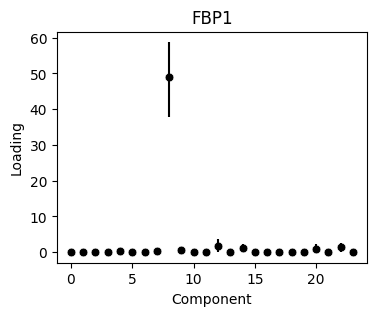

In [28]:
print(Panel("\n\n"+"\t".join(gene_programs[factor])+"\n\n", title="Filtered genes based on entropy and absolute loading"))
fig = reconstructed_all.plot_gene_across_components(rank=rank, gene=gene_programs[factor][0], restart_index=0)

╭──────────────────────────────────────────╮
│ Unfiltered but normalized across factors │
╰──────────────────────────────────────────╯

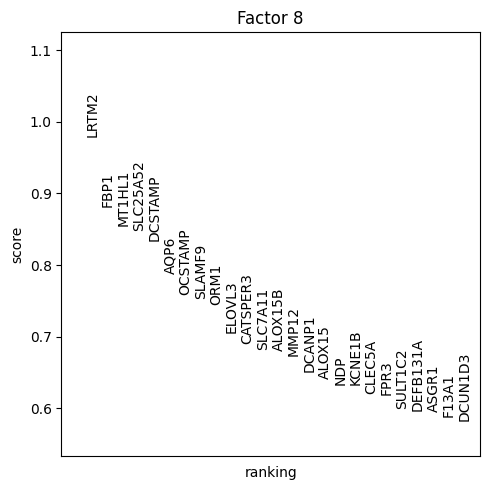

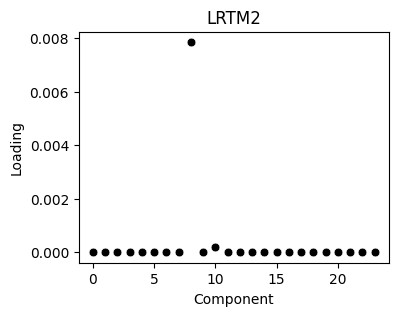

In [13]:
display(Panel.fit(f"Unfiltered but normalized across factors"))
fig, factors = reconstructed_all.gene_factor_elbow_plots(
    rank=24, restart_index=0, factor_index=factor, num_genes=25, normalize=True, fontsize=10, figsize=(5,5))
fig = reconstructed_all.plot_gene_across_components(rank=rank, gene=factors.sort_values(factor, ascending=False).index[0], restart_index=0)

╭──────────────────────────────╮
│ Unfiltered and Unnormalized  │
╰──────────────────────────────╯

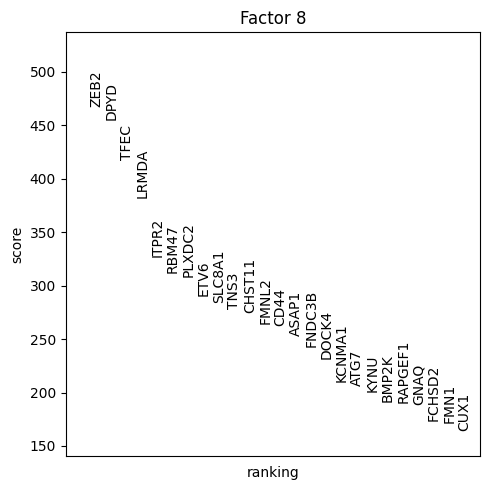

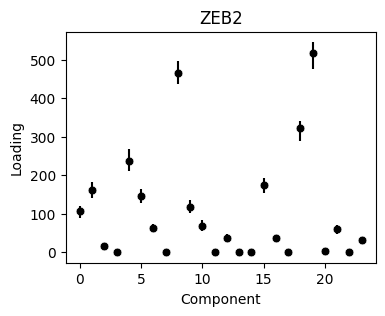

In [14]:
display(Panel.fit(f"Unfiltered and Unnormalized "))
fig, factors = reconstructed_all.gene_factor_elbow_plots(
    rank=rank, restart_index=0, factor_index=factor, num_genes=25, normalize=False, fontsize=10, figsize=(5,5))
fig = reconstructed_all.plot_gene_across_components(rank=rank, gene=factors.sort_values(factor, ascending=False).index[0], restart_index=0)

## 7. Validating top genes in the GEP using raw expression

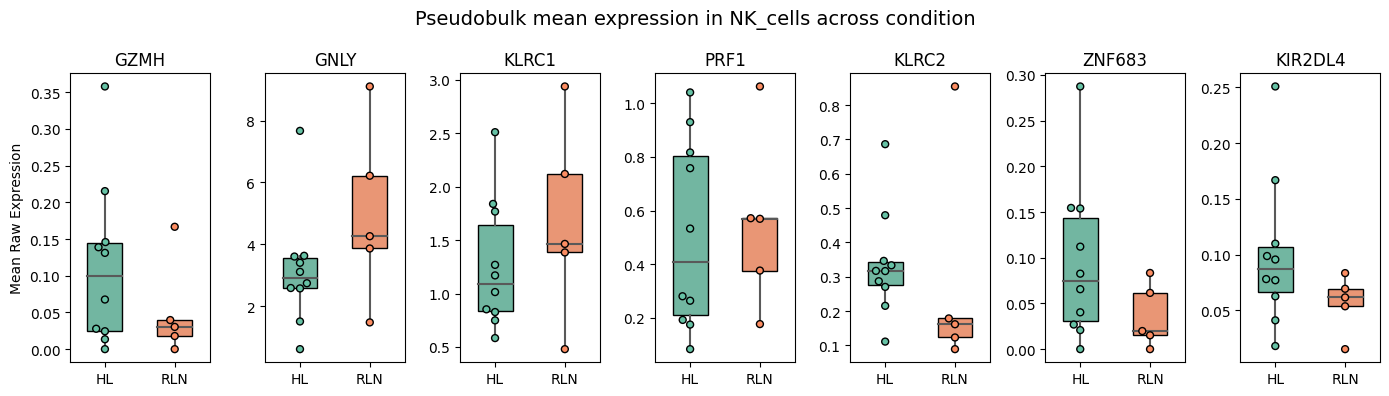

In [31]:
"""

    V

"""

ctype = reconstructed_all.sc_tensor.celltype_list[ct_factor.argmax()]

fig, axs = plt.subplots(1,7,figsize=(14, 4))
xlab = None
for ax, gene in zip(axs, gene_programs[factor][:7]):
    FactorizationSet.case_control_1v1(
        adata=adata, 
        gene=gene, 
        celltype=ctype, 
        iv='condition', 
        donor_label='donor', 
        celltype_label='cell_types_level_3', 
        ax=ax,
        title=gene,
        xlab=xlab
    )
    xlab = ''
fig.suptitle(f"Pseudobulk mean expression in {ctype} across condition", fontsize=14)
fig.tight_layout()
plt.show()

## 8. Gene Set Over-representation Analysis (hypergeometric test)

In [68]:
"""
    
    
    
"""

for gset in ['GO_Biological_Process_2021']:
    display(Panel.fit(f"[bold green]{gset}", border_style="green"))
    display(gp.enrichr(
        gene_list=gene_programs[factor], 
        gene_sets=gset, 
        organism='human', 
        background=reconstructed_all.sc_tensor.gene_list, 
        outdir=None
    ).results.head(5).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='.col1', props=[('min-width', '300px')])]))

╭────────────────────────────╮
│ GO_Biological_Process_2021 │
╰────────────────────────────╯

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of immune response (GO:0050776),20/179,0.000000,0.000000,0,0,19.201404,767.869597,CD96;LAG3;KLRB1;CD300A;CRTAM;SH2D1B;PTPN22;SLA2;ITGAL;KIR2DL4;NCR1;CD8B;CD8A;KLRF1;KLRD1;SLAMF6;CD226;ITGB7;KLRC1;CD247
1,GO_Biological_Process_2021,T cell activation (GO:0042110),12/92,0.000000,0.000000,0,0,21.647080,567.787724,CD2;ZAP70;CD8B;CD8A;LCK;KIT;CRTAM;CD7;PTPN22;NLRC3;GATA3;SLA2
2,GO_Biological_Process_2021,regulation of natural killer cell mediated cytotoxicity (GO:0042269),8/30,0.000000,0.000000,0,0,51.138620,1224.371730,NCR1;KLRC2;CRTAM;SLAMF6;CD226;KLRD1;KLRC1;KIR2DL4
3,GO_Biological_Process_2021,positive regulation of natural killer cell mediated immunity (GO:0002717),7/23,0.000000,0.000000,0,0,61.111356,1352.336727,KLRC2;CRTAM;SH2D1B;CD226;KLRD1;SLAMF6;KIR2DL4
4,GO_Biological_Process_2021,regulation of T cell receptor signaling pathway (GO:0050856),7/35,0.000000,0.000002,0,0,34.899648,659.327510,CD300A;LCK;PTPN22;CD226;UBASH3A;SLA2;CARD11


## 9. Preranked Gene Set Enrichment Analysis

╭────────────────────────────╮
│ GO_Molecular_Function_2021 │
╰────────────────────────────╯

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,MHC protein binding (GO:0042287),0.893911,1.801625,0.000000,0.006848,0.007000,8/24,4.39%,CD8A;CD244;CD8B;KIR3DL2;LAG3;FCRL6;COL2A1;PILRB
2,prerank,CXCR chemokine receptor binding (GO:0045236),0.911346,1.769553,0.000000,0.011739,0.035000,1/13,8.86%,ITCH
1,prerank,chemoattractant activity (GO:0042056),0.865397,1.780466,0.000000,0.012717,0.025000,2/25,0.49%,CCL5;MIF
4,prerank,chemokine activity (GO:0008009),0.818111,1.744485,0.000000,0.013304,0.062000,6/42,3.78%,XCL1;CCL5;XCL2;CCL4;CCL1;CCL25
6,prerank,CCR chemokine receptor binding (GO:0048020),0.831925,1.734709,0.000000,0.013695,0.087000,6/33,3.78%,XCL1;CCL5;XCL2;CCL4;CCL1;CCL25


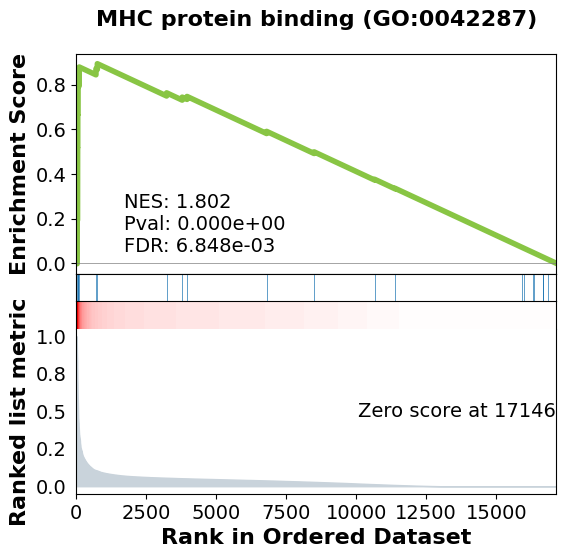

╭───────────────╮
│ Reactome_2022 │
╰───────────────╯

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Immunoregulatory Interactions Between A Lymphoid And A non-Lymphoid Cell R-HSA-198933,0.876603,1.965260,0.000000,0.000000,0.000000,32/114,4.97%,KIR3DL1;KLRC1;KIR2DL3;KIR2DL4;KLRF1;CD8A;SH2D1B;KLRD1;NCR1;CD8B;KIR3DL2;CD247;CRTAM;CD160;CD96;KLRG1;KLRB1;NCR3;CD300A;SLAMF6;ITGAL;ITGB7;CD226;ULBP3;CD200R1;CD3E;SELL;ITGA4;CLEC2D;CD3D;HCST;NCR2
1,prerank,Translocation Of ZAP-70 To Immunological Synapse R-HSA-202430,0.959435,1.864435,0.000000,0.000000,0.000000,6/14,4.09%,CD247;ZAP70;PTPN22;LCK;CD3E;CD3D
2,prerank,Chemokine Receptors Bind Chemokines R-HSA-380108,0.843252,1.833676,0.000000,0.000662,0.002000,12/55,3.78%,XCL1;CCL5;CXCR6;XCL2;CXCR3;CCR5;CX3CR1;CCR9;CCL4;CCL1;ACKR2;CCL25
4,prerank,Nucleotide-like (Purinergic) Receptors R-HSA-418038,0.917620,1.790411,0.000000,0.003177,0.015000,2/14,3.88%,P2RY4;P2RY10
3,prerank,Phosphorylation Of CD3 And TCR Zeta Chains R-HSA-202427,0.904852,1.795198,0.000000,0.003227,0.012000,8/17,6.39%,CD247;PTPN22;LCK;CD3E;CD3D;PTPRC;CSK;PAG1


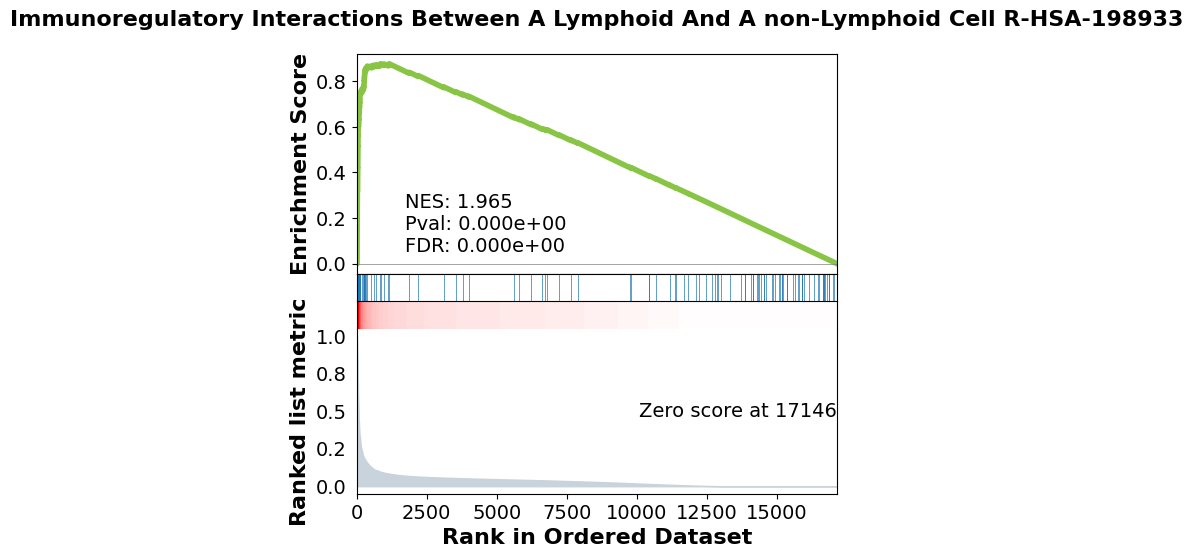

╭──────────────────────╮
│ MSigDB_Hallmark_2020 │
╰──────────────────────╯

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Allograft Rejection,0.761928,1.739813,0.000000,0.000000,0.000000,45/192,5.97%,PRF1;CD8A;IL2RB;KLRD1;CCL5;NCR1;CD8B;GZMA;IFNG;CD247;CRTAM;CD7;CD2;STAT4;CD96;IL18RAP;ZAP70;GZMB;F2R;CXCR3;CCR5;TRAT1;FASLG;LCK;ITGAL;IL11;ITK;CD3E;CCL4;IL27RA;CD3G;CCND3;MAP4K1;IL12RB1;LIF;LCP2;CD3D;GPR65;PTPRC;ETS1;IL16;IL2RG;GLMN;CDKN2A;CSK
1,prerank,Inflammatory Response,0.650760,1.486432,0.000000,0.004900,0.010000,22/197,7.09%,NMUR1;IL2RB;CCL5;CXCR6;IL18RAP;CD69;PTGER2;LCK;SELL;SLC4A4;IL18R1;SEMA4D;LIF;IL10RA;LCP2;RASGRP1;KCNMB2;KCNA3;IL7R;CD48;TLR3;CCL24
4,prerank,Apical Surface,0.634173,1.342608,0.012000,0.034104,0.158000,8/44,10.44%,IL2RB;CD160;GATA3;SLC22A12;AFAP1L2;IL2RG;AKAP7;MDGA1
2,prerank,Epithelial Mesenchymal Transition,0.599640,1.371162,0.000000,0.036587,0.104000,8/197,5.04%,PRSS2;AREG;SNTB1;GPX7;IL32;MAGEE1;TGFBR3;WIPF1
3,prerank,IL-2/STAT5 Signaling,0.588820,1.351077,0.000000,0.037975,0.140000,33/196,10.03%,IL2RB;CST7;EOMES;PRKCH;TNFRSF18;ITGAE;PTGER2;TTC39B;IKZF2;F2RL2;AMACR;ABCB1;SELL;IL18R1;GALM;CCND3;GABARAPL1;CSF2;LIF;IL10RA;TIAM1;GPR65;CDC42SE2;RHOH;GLIPR2;CD48;PIM1;DHRS3;HOPX;FURIN;BATF;BCL2L1;SNX14


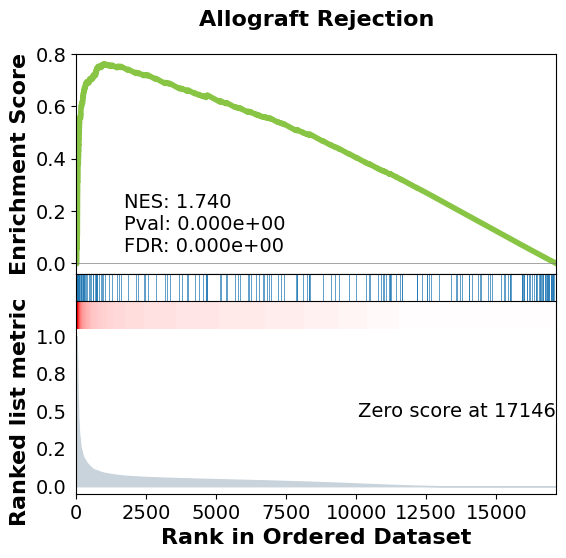

╭─────────────────╮
│ KEGG_2021_Human │
╰─────────────────╯

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Graft-versus-host disease,0.938680,1.991109,0.000000,0.000000,0.000000,11/38,1.37%,KIR3DL3;KIR3DL1;PRF1;KLRC1;KIR2DL3;KIR2DL1;KLRD1;KIR3DL2;IFNG;GZMB;FASLG
1,prerank,Antigen processing and presentation,0.895311,1.946736,0.000000,0.000000,0.000000,12/65,0.36%,KIR3DL3;KIR3DL1;KLRC1;KIR2DL3;KIR2DL4;KLRC2;KIR2DL1;CD8A;KLRD1;CD8B;KIR3DL2;IFNG
2,prerank,Natural killer cell mediated cytotoxicity,0.819210,1.825544,0.000000,0.000000,0.000000,38/101,7.17%,KIR3DL3;KIR3DL1;PRF1;KLRC1;KIR2DL3;KLRC2;KIR2DL1;SH2D1B;KLRD1;NCR1;CD244;KIR3DL2;IFNG;CD247;ZAP70;FYN;GZMB;NCR3;FASLG;LCK;ITGAL;ULBP3;NFATC2;RAC2;PIK3R1;PIK3CD;CSF2;PPP3CC;LCP2;HCST;NCR2;LAT;VAV3;CD48;MAPK1;MICB;ULBP2;PLCG1
3,prerank,Hematopoietic cell lineage,0.801245,1.786239,0.000000,0.000250,0.001000,16/92,6.02%,CD8A;CD8B;CD7;CD2;IL9R;IL11;CD3E;KIT;ITGA1;GYPA;CD3G;ITGA4;CSF2;CD3D;IL11RA;IL7R
4,prerank,Viral protein interaction with cytokine and cytokine receptor,0.770524,1.713121,0.000000,0.000800,0.004000,18/95,7.11%,IL2RB;XCL1;CCL5;XCL2;IL18RAP;CXCR3;CCR5;CX3CR1;CCR9;CCL4;IL18R1;CCL1;IL24;CCL25;IL10RA;IL2RG;CCL24;IL20


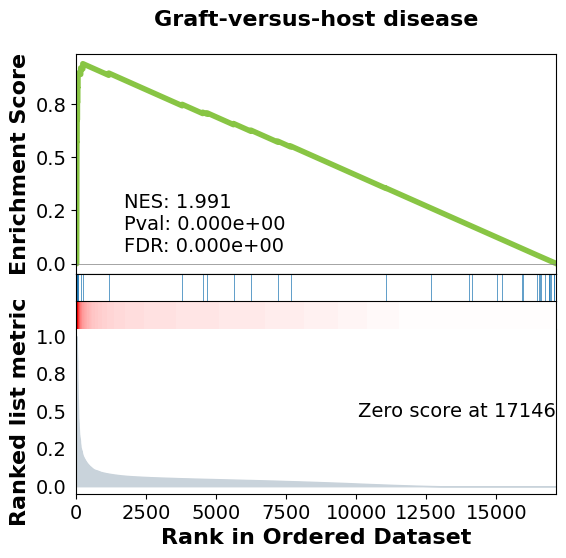

In [98]:
"""

    P

"""

gene_factor = reconstructed_all.get_factorization(rank=rank, restart_index=0).gene_factor['mean'].numpy()
gene_factor = pd.DataFrame(gene_factor, index=reconstructed_all.sc_tensor.gene_list)
normed_gene_factor = (gene_factor.T/gene_factor.T.sum()).T
for gset in ['GO_Molecular_Function_2021', 'Reactome_2022', 'MSigDB_Hallmark_2020', 'KEGG_2021_Human']:
    display(Panel.fit(f"[bold green]{gset}", border_style="green"))
    pre_res = gp.prerank(
        rnk=normed_gene_factor[[factor]], 
        gene_sets=gset,
        threads=8, min_size=10, permutation_num=1000, 
        outdir=None, seed=6, verbose=False
    )
    styles = [dict(selector='.col1', props=[('min-width', '300px')])]
    display(pre_res.res2d[pre_res.res2d.ES > 0].sort_values('FDR q-val').head(5).style.set_properties(**{'text-align': 'left'}).set_table_styles(styles))
    term = pre_res.res2d[pre_res.res2d.ES > 0].sort_values('FDR q-val').Term.values[0]
    gseaplot(rank_metric=pre_res.ranking, term=term, **pre_res.results[term])
    plt.show()

## 10. Miscelaneous 

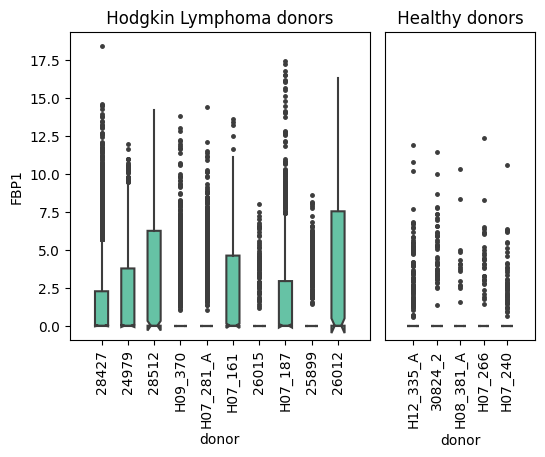

In [146]:
# FactorizationSet.gene_box_plot(adata, gene_programs[factor][0], ctype, 'condition', ptype='box')